In [1]:
%load_ext autoreload
%autoreload 2
# import os, sys, time, math
# sys.path.append('/home/blanca/projects/deeplabv3/')
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

In [2]:
import os
import numpy as np
import torch
from PIL import Image

import os
import torch
import torchvision
from pathlib import Path
from torchvision.models.segmentation import deeplabv3_resnet101

import engine
import transforms as T
import utils

from dataset import SegDataset
from open_images import OpenImagesDataset

from models.deeplabv3 import DeepLabHead
from models.fcn import FCNHead

os.environ["CUDA_VISIBLE_DEVICES"]='2 3'


def load_model(pretrained=False):

    model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=pretrained)        
    np_model = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'DeppLabv3 -- num. of learnable parameters: {np_model}') 

    return model

def get_transform(train):

    transforms = []
    transforms.append(T.ToTensor())
#     if train:
#         transforms.append(T.RandomHorizontalFlip(0.5))
    return transforms

if __name__== "__main__":
    
    torch.cuda.empty_cache()

    dbroot = '/datasets/OpenImages/processedv4'
    dataset_train = SegDataset(os.path.join(dbroot, 'test'), get_transform(train=True))
    dataset_val = SegDataset(os.path.join(dbroot, 'validation'), get_transform(train=False))

    # define training and validation data loaders
    data_loader_train = torch.utils.data.DataLoader(
        dataset_train, batch_size=2, shuffle=True, num_workers=4)
#         collate_fn=utils.collate_fn)

    data_loader_val = torch.utils.data.DataLoader(
        dataset_val, batch_size=1, shuffle=False, num_workers=4)
#         collate_fn=utils.collate_fn)

    # model
    model = load_model(pretrained=True)
    num_classes = 1
    aux=True
    if aux:
        inplanes = 1024
        aux_classifier = FCNHead(inplanes, num_classes)

    inplanes = 2048
    classifier = DeepLabHead(inplanes, num_classes)
    
    model.classifier = classifier
    model.aux_classifier = aux_classifier

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=9,
                                                   gamma=0.1)

    # let's train it for 10 epochs
    num_epochs = 30
    
    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        engine.train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        # evaluate(model, data_loader_test, device=device)


    # for i in range(len(dataset)):|
    #     it = dataset.__getitem__(i)

DeppLabv3 -- num. of learnable parameters: 60996202
torch.cuda.FloatTensor torch.cuda.FloatTensor
out tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]],


        [[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
target tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ...,

/home/blanca/projects/deeplabv3/engine.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.functional.softmax(x)


RuntimeError: 1only batches of spatial targets supported (non-empty 3D tensors) but got targets of size: : [2, 1, 300, 300]

In [ ]:
for i in range(len(dataset_train)):
    it = dataset_train.__getitem__(i)
    ims, labs = it
    print(ims.shape, labs['mask'].shape)
    if i == 10: break

In [28]:


ims = ims.numpy().transpose((1,2,0))

boxes = labs['boxes'].numpy()
polys = labs['polys']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


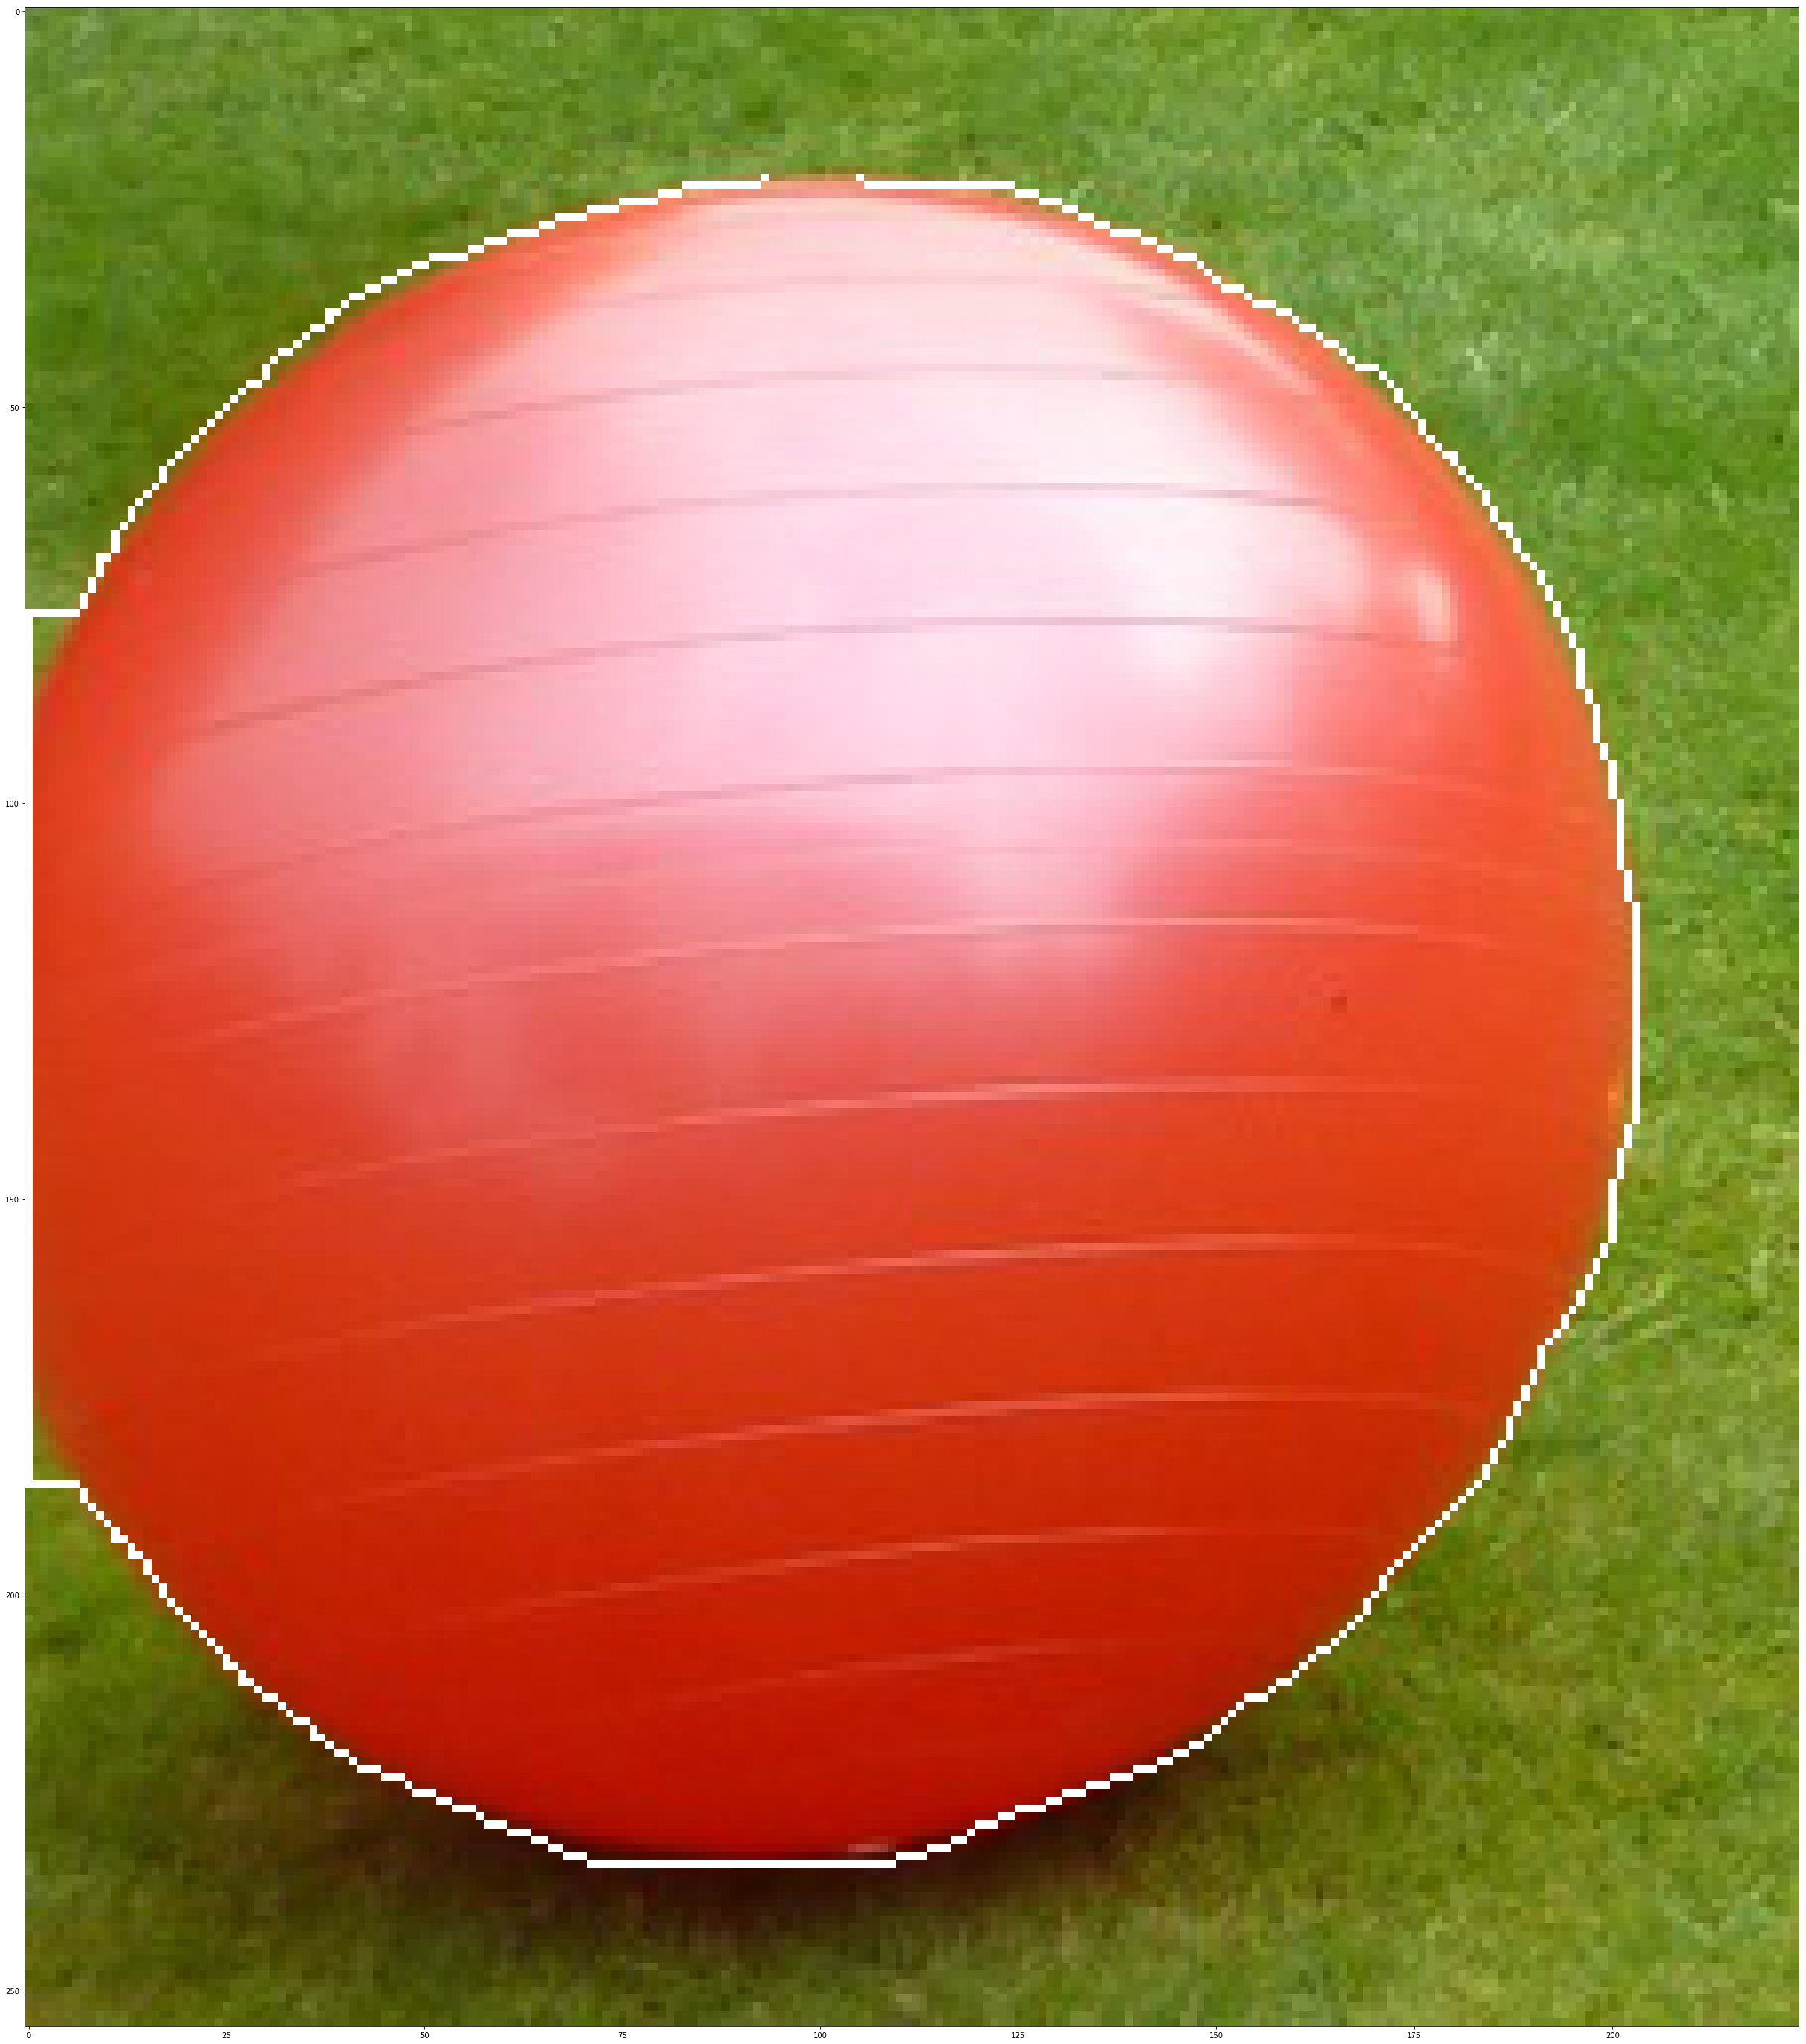

In [29]:
ims1 = np.ascontiguousarray(ims)
cv2.polylines(ims1, [polys], False, (255, 255, 255), 1)
plt.figure(figsize=(50, 50))
plt.imshow(ims1)

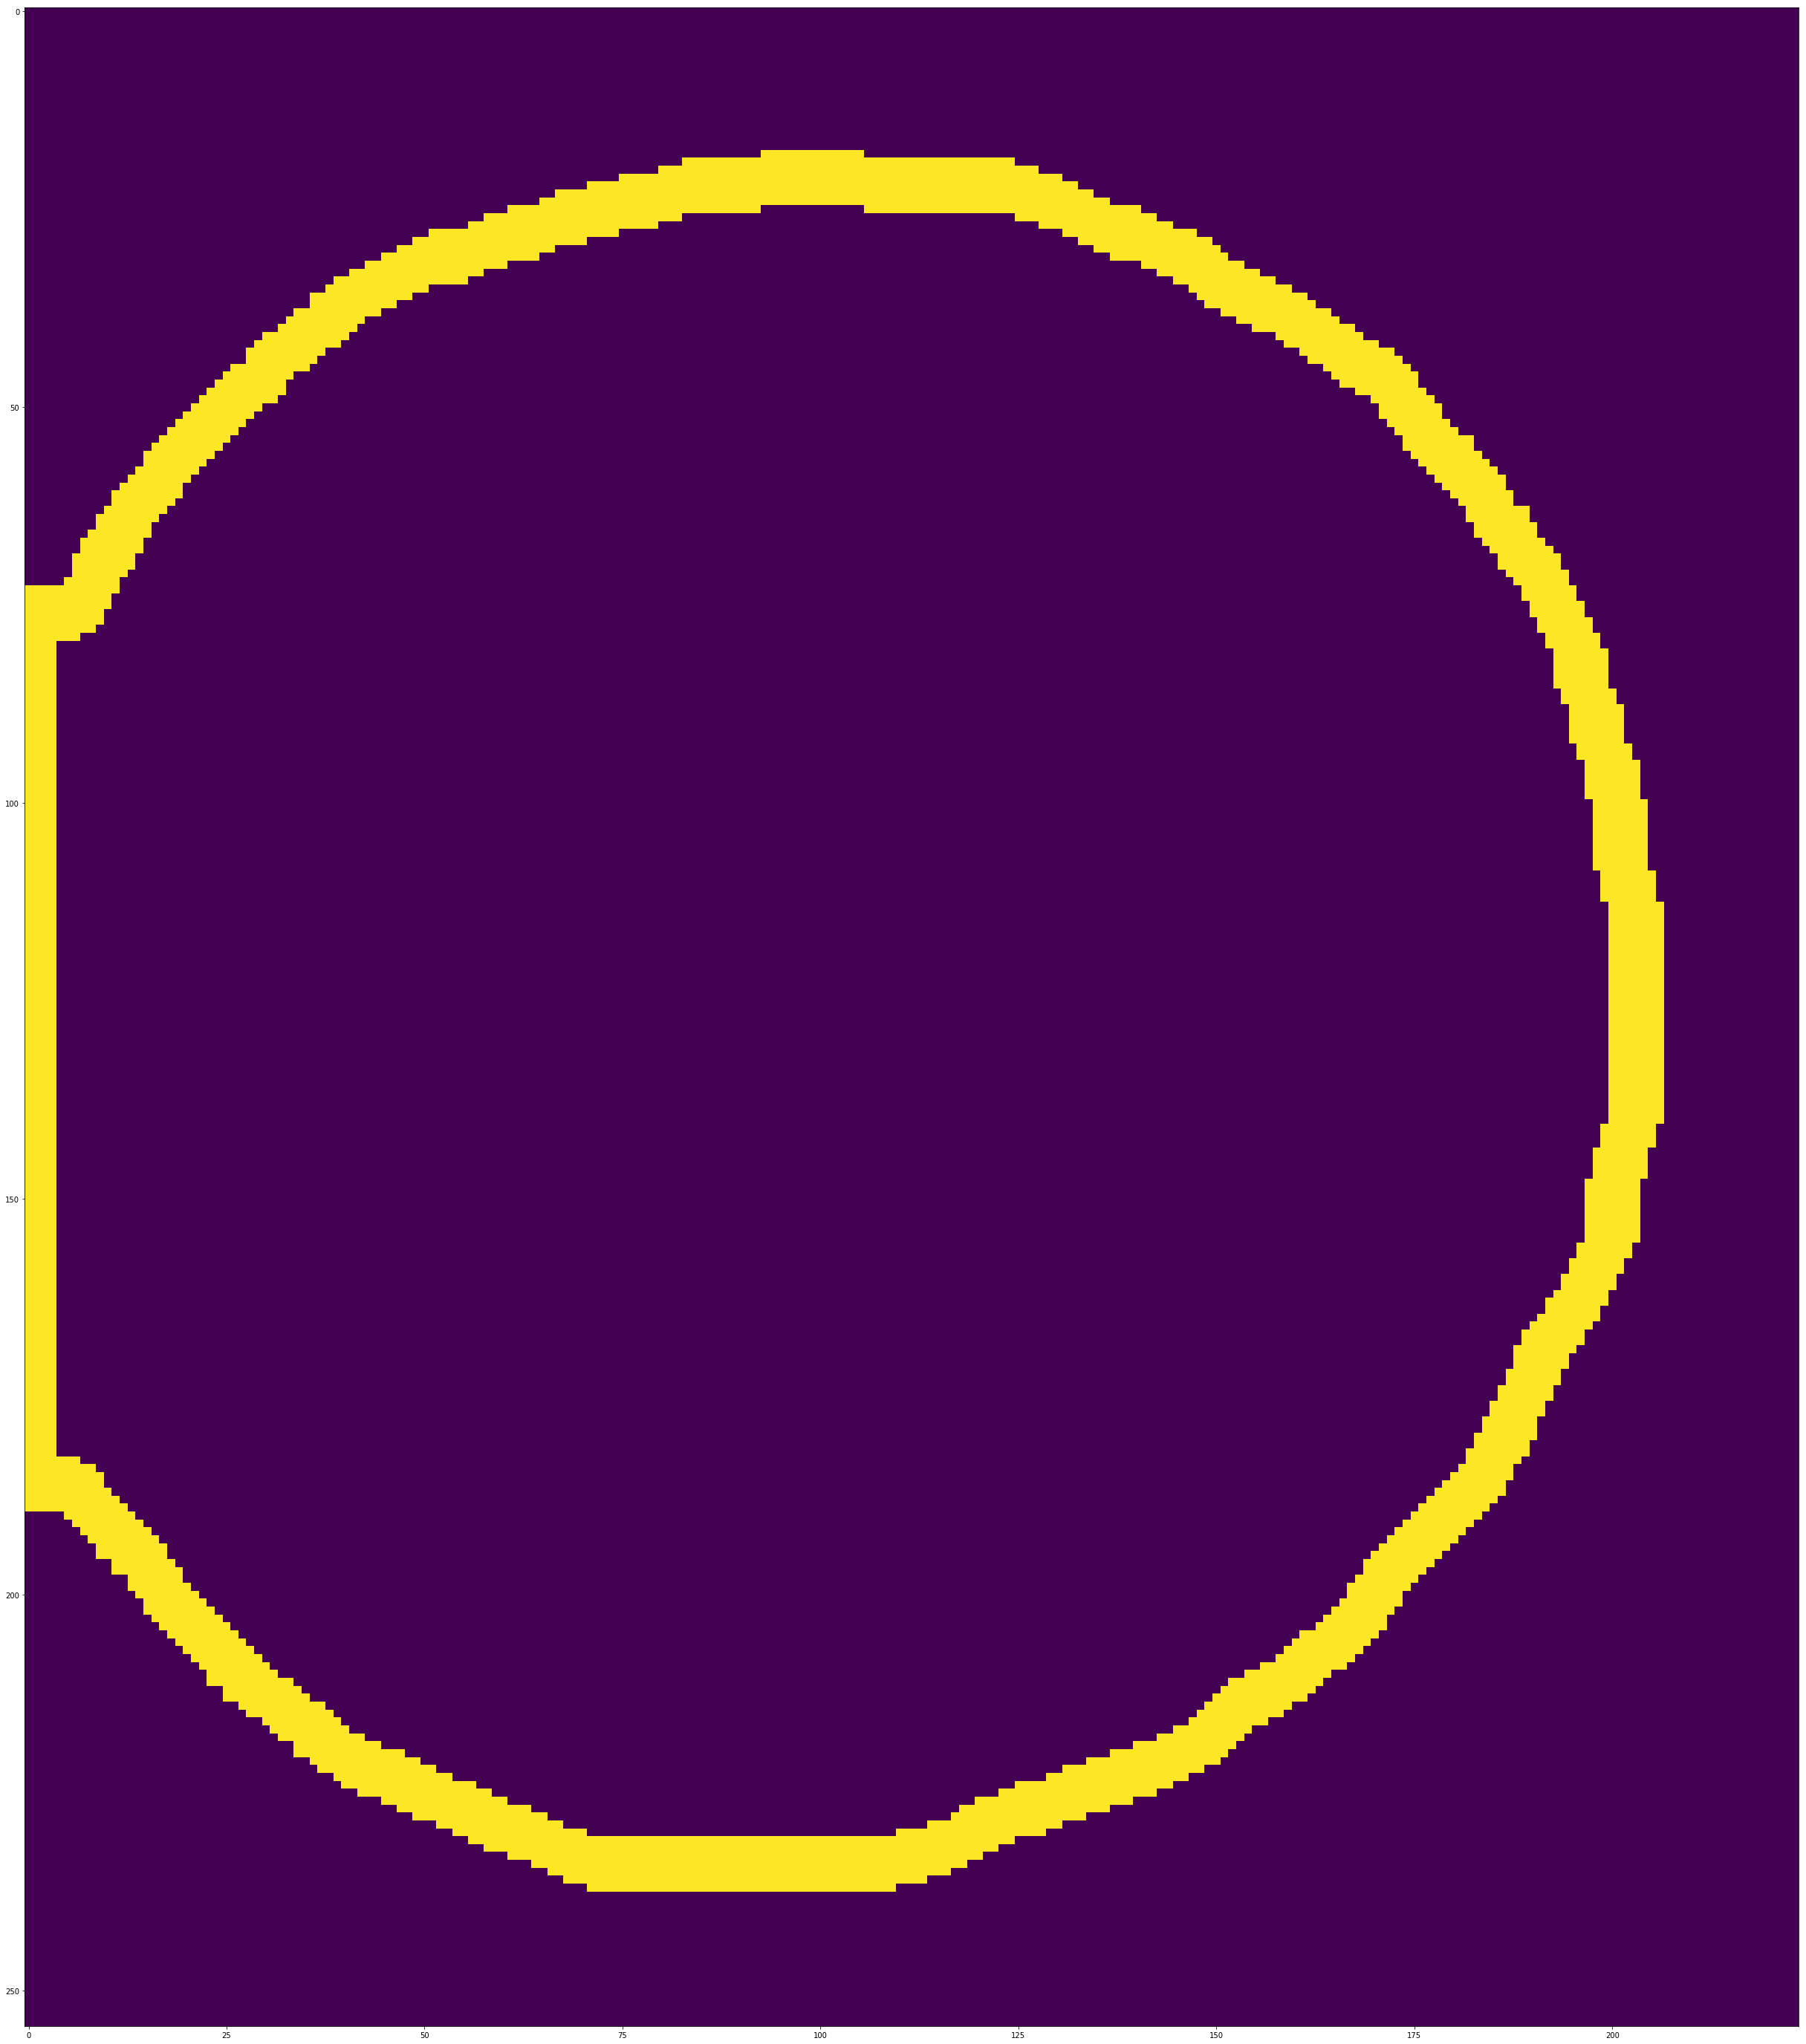

In [31]:
mask = labs['mask']
plt.figure(figsize=(50, 50))
plt.imshow(mask)

In [71]:
torch.tensor(mask, )

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

In [60]:
import torch
import torchvision
model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True, aux_loss=False)

# new_model.backbone = model.backbone
# new_model.classifier = model.classifier
# new_model

In [54]:
modules=list(model.modules())[:-1]
m2=torch.nn.Sequential(*modules)

In [58]:
torch.nn.ModuleList([model.backbone, model.classifier])

ModuleList(
  (0): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
      

In [25]:
model.backbone
model.classifier
model.aux_classifier

FCNHead(
  (0): Conv2d(1024, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.1)
  (4): Conv2d(256, 21, kernel_size=(1, 1), stride=(1, 1))
)

SyntaxError: invalid syntax (<ipython-input-21-c12811a4c4a2>, line 1)